<a href="https://colab.research.google.com/github/ericyoc/post_quantum_falcon_crypto_sig_poc/blob/main/post_quantum_falcon_crypto_sig_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstration of Post Quantum Resilency Algorithm: Fast-Fourier Lattice-based Compact Signatures over NTRU (FALCON Algorithm) found at https://falcon-sign.info/

NTRU is an open-source public-key cryptosystem that uses lattice-based cryptography to encrypt and decrypt data.

In [1]:
#!git clone https://github.com/tprest/falcon.py.git
%cd /content/falcon
#!pip install numpy
#!pip install pycryptodome

/content/falcon


In [2]:
import falcon
import time
import hashlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import textwrap

In [3]:
def load_image(url):
    """
    Downloads an image from the given URL and returns it as a PIL Image object.
    """
    import requests
    from io import BytesIO
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

In [4]:
def image_to_bytes(image):
    """
    Converts a PIL Image object to a byte string.
    """
    import io
    with io.BytesIO() as output:
        image.save(output, format="PNG")
        return output.getvalue()

In [5]:
def bytes_to_image(byte_string):
    """
    Converts a byte string to a PIL Image object.
    """
    from io import BytesIO
    return Image.open(BytesIO(byte_string))

In [6]:
def sign_image(image, secret_key, max_retries=100):
    """
    Signs an image using the Falcon signature algorithm.
    Retries the signing process if the signature norm is too large.
    """
    image_bytes = image_to_bytes(image)
    retry_count = 0
    error_message = None
    while True:
        try:
            signature = secret_key.sign(image_bytes)
            print(f"Signature generated successfully after {retry_count} retries.")
            return signature, error_message
        except ValueError as e:
            if "Squared norm of signature is too large" in str(e):
                retry_count += 1
                print(f"Signature norm too large. Retrying ({retry_count}/{max_retries})...")
                error_message = str(e)
                if retry_count >= max_retries:
                    return None, error_message
            else:
                raise e

In [7]:
def verify_image(image, signature, public_key):
    """
    Verifies the signature of an image using the Falcon signature algorithm.
    """
    image_bytes = image_to_bytes(image)
    return public_key.verify(image_bytes, signature)

In [8]:
def main():
    # Set the security parameter (recommended values: 512, 1024)
    n = 1024  # Revert to a supported security parameter

    # Generate a secret key and the corresponding public key
    secret_key = falcon.SecretKey(n)
    public_key = falcon.PublicKey(secret_key)

    # Load a sample image from the URL
    image_url = "https://picsum.photos/200/300"
    image = load_image(image_url)

    # Sign the image
    start_time = time.time()
    signature, error_message = sign_image(image, secret_key)
    sign_time = time.time() - start_time

    # Create a results table
    table = PrettyTable()
    table.field_names = ["Metric", "Value", "Explanation"]
    table.align["Metric"] = "l"
    table.align["Value"] = "l"
    table.align["Explanation"] = "l"

    # Add algorithm metrics to the results table
    table.add_row(["Algorithm", "Falcon", "The name of the post-quantum signature algorithm used"])
    table.add_row(["Security Parameter (n)", n, "The security parameter used for key generation"])
    table.add_row(["Signature Time", f"{sign_time:.6f} seconds", "The time taken to generate the signature"])

    if signature is not None:
        # Verify the signature
        start_time = time.time()
        is_valid = verify_image(image, signature, public_key)
        verify_time = time.time() - start_time

        # Add signature-related metrics to the results table
        table.add_row(["Signature Length", len(signature), "The length of the generated signature in bytes"])
        table.add_row(["Verification Time", f"{verify_time:.6f} seconds", "The time taken to verify the signature"])
        table.add_row(["Is Signature Valid?", is_valid, "Indicates whether the signature is valid for the original image"])

        # Perform additional checks
        signature_hex = signature.hex()
        signature_hex_wrapped = '\n'.join(textwrap.wrap(signature_hex, width=64))
        table.add_row(["Signature Hex Representation", signature_hex_wrapped, "The hexadecimal representation of the signature"])

        # Load a different image
        different_image_url = "https://picsum.photos/200/300?random=1"
        different_image = load_image(different_image_url)

        # Verify signature with the different image
        is_different_image_valid = verify_image(different_image, signature, public_key)
        table.add_row(["Is Different Image Valid?", is_different_image_valid, "Checks if the signature is valid for a different image (should be False)"])

        # Create a tampered image
        tampered_image = image.copy()
        tampered_image.putpixel((0, 0), (255, 0, 0))

        # Verify signature with the tampered image
        is_tampered_image_valid = verify_image(tampered_image, signature, public_key)
        table.add_row(["Is Tampered Image Valid?", is_tampered_image_valid, "Checks if the signature is valid for a tampered image (should be False)"])
    else:
        # Add error message to the table if signature generation failed
        table.add_row(["Error Message", error_message, "The error message encountered during signature generation"])

    # Display the original image
    print("Original Image:")
    plt.imshow(image)
    plt.show()

    # Display the different image
    if signature is not None:
        print("Different Image:")
        plt.imshow(different_image)
        plt.show()

        # Display the tampered image
        print("Tampered Image:")
        plt.imshow(tampered_image)
        plt.show()

    # Print the results table
    print(table)

Signature generated successfully after 0 retries.
Squared norm of signature is too large: 12648684505
Squared norm of signature is too large: 12645896877
Original Image:


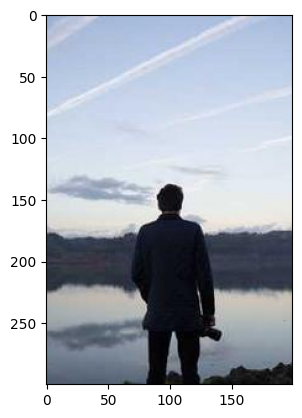

Different Image:


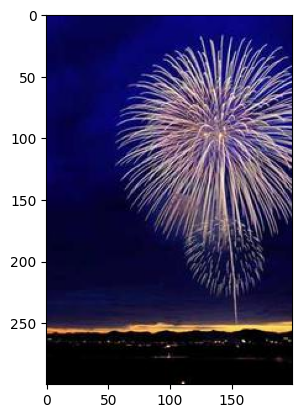

Tampered Image:


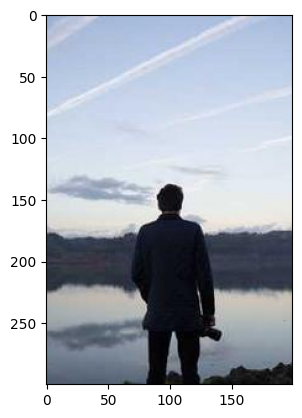

+------------------------------+------------------------------------------------------------------+--------------------------------------------------------------------------+
| Metric                       | Value                                                            | Explanation                                                              |
+------------------------------+------------------------------------------------------------------+--------------------------------------------------------------------------+
| Algorithm                    | Falcon                                                           | The name of the post-quantum signature algorithm used                    |
| Security Parameter (n)       | 1024                                                             | The security parameter used for key generation                           |
| Signature Time               | 0.177764 seconds                                                 | The time taken to generat

In [9]:
if __name__ == "__main__":
    main()